In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import xlrd

from sqlalchemy import create_engine, text, Integer, String, Column
from sqlalchemy.exc import SQLAlchemyError
from sqlalchemy.ext.declarative import declarative_base

# Etapa 1 - Extração e Carregamento dos Dados

- ✅ **Escolha dos Dados**: Escolher um conjunto de dados que seja relevante para o candidato e que permita a aplicação de técnicas de análise de dados.
- ✅ **Extração**: Utilizar a linguagem de programação Python e bibliotecas como requests, pandas, sqlalchemy para extrair os dados da fonte escolhida.
- ✅ **Transformação**: Limpar e transformar os dados para garantir a qualidade e consistência.
- ❎ **Carregamento**: Carregar os dados transformados em um banco de dados relacional (PostgreSQL, MySQL, etc.), utilizando o SQLAlchemy para a conexão e inserção dos dados.


## **Escolha, Extração e Transformação dos Dados**

### Tabela 1: Projeções  FEITO

In [181]:
# Lendo o arquivo xlsx
# Excluída as 6 primeiras linhas, visto que não são necessárias para a manipulação dos dados
projecoes_df = pd.read_excel("Tabelas/projecoes_2024_tab4_indicadores.xlsx", skiprows=6)

# Filtrar linhas e colunas necessárias
projecoes2_df_filtrado = projecoes_df[
    (projecoes_df["LOCAL"].str.strip() == "Brasil") &                                                     # LOCAL == "Brasil" 
    (projecoes_df["ANO"].astype(float).between(2018, 2024) | (projecoes_df["ANO"].astype(float) == 2045)) # ANO no intervalo [2018, 2025] ou [2045]
]

# Selecionar apenas as colunas desejadas
colunas_desejadas = ["ANO", "LOCAL", "POP_H", "POP_M", "e0_T", "e60_T"]
projecoes2_df_filtrado = projecoes2_df_filtrado[colunas_desejadas]
projecoes2_df_filtrado = projecoes2_df_filtrado.rename(columns={
    "ANO": "year",
    "LOCAL": "local",
    "POP_H": "pop_h",
    "POP_M": "pop_m",
    "e0_T": "e0_t",
    "e60_T": "e60_t"
})

projecoes2_df_filtrado

,year,local,pop_h,pop_m,e0_t,e60_t
18,2018,Brasil,100895555,105633483,75.990227,22.206781
19,2019,Brasil,101551234,106348865,76.221101,22.254800
20,2020,Brasil,102140954,107023935,74.809005,21.169615
21,2021,Brasil,102550853,107552789,72.784302,20.084039
22,2022,Brasil,102875114,107987869,75.448044,21.619386
23,2023,Brasil,103251553,108443605,76.388455,22.470774
24,2024,Brasil,103662286,108921464,76.605711,22.590940
45,2045,Brasil,106861156,113184535,80.540082,24.724144


### Tabela 2: Perfil etário e socioeconômico FEITO

In [178]:
# Definindo as colunas desejadas e faixas para os subconjuntos
colunas_desejadas = {
    "Características selecionadas": "features",
    "População na força de trabalho\n(1 000 pessoas)": "work_pop"
}

faixas = {
    "homens": (15, 22),  # Homens: linhas 18 a 25
    "mulheres": (24, 31) # Mulheres: linhas 27 a 34
}

# Lista com os anos
anos = ["2018", "2019", "2020", "2021", "2022", "2023"]

# Função para carregar e processar os dados
def carregar_etario(ano):
    df = pd.read_excel(
        "Tabelas/tabela_1_1_Indic_BR.xls",
        sheet_name=ano,
        skiprows=2,
        usecols=list(colunas_desejadas.keys())
    ).rename(columns=colunas_desejadas)
    df['year'] = ano
    return df

# Função para processar os subconjuntos
def processar_subconjuntos(df):
    return {
        faixa: df.iloc[inicio:fim].assign(sex=sexo)
        for faixa, (inicio, fim), sexo in zip(faixas.keys(), faixas.values(), ['H', 'M'])
    }

# Carregar dados e processar todos os anos
etario_filtrado = pd.concat(
    [
        pd.concat(processar_subconjuntos(carregar_etario(ano)).values(), axis=0, ignore_index=True)
        for ano in anos
    ], 
    axis=0, ignore_index=True
)

# Ajustes finais no DataFrame
etario_filtrado = etario_filtrado[["year", "sex", "features", "work_pop"]]
etario_filtrado["work_pop"] *= 1000

# Remover as linhas indesejadas
etario_filtrado = etario_filtrado[~etario_filtrado["features"].isin(["14 a 17 anos", "18 a 24 anos", "25 a 29 anos"])]

# Resetar os índices
etario_filtrado = etario_filtrado.reset_index(drop=True)

# Exibir o DataFrame filtrado
etario_filtrado


,year,sex,features,work_pop
0,2018,H,14 a 29 anos,1.857992e+07
1,2018,H,30 a 49 anos,2.774320e+07
2,2018,H,50 a 59 anos,8.655983e+06
3,2018,H,60 anos ou mais,4.308652e+06
4,2018,M,14 a 29 anos,1.455251e+07
5,2018,M,30 a 49 anos,2.292031e+07
6,2018,M,50 a 59 anos,6.513811e+06
7,2018,M,60 anos ou mais,2.347598e+06
8,2019,H,14 a 29 anos,1.868700e+07
9,2019,H,30 a 49 anos,2.806768e+07


In [172]:
# Definindo as colunas desejadas e faixas para os subconjuntos
colunas_desejadas = {
    "Características selecionadas": "degree",
    "População na força de trabalho\n(1 000 pessoas)": "work_pop"
}

faixas = {
    "homens": (58, 62),  # Homens: linhas 18 a 25
    "mulheres": (64, 68) # Mulheres: linhas 27 a 34
}

# Lista com os anos
anos = ["2018", "2019", "2020", "2021", "2022", "2023"]

# Função para carregar e processar os dados
def carregar_dados(ano):
    df = pd.read_excel(
        "Tabelas/tabela_1_1_Indic_BR.xls",
        sheet_name=ano,
        skiprows=2,
        usecols=list(colunas_desejadas.keys())
    ).rename(columns=colunas_desejadas)
    df['year'] = ano
    return df

# Função para processar os subconjuntos
def processar_subconjuntos(df):
    return {
        faixa: df.iloc[inicio:fim].assign(sex=sexo)
        for faixa, (inicio, fim), sexo in zip(faixas.keys(), faixas.values(), ['H', 'M'])
    }

# Carregar dados e processar todos os anos
socio_filtrado = pd.concat(
    [
        pd.concat(processar_subconjuntos(carregar_dados(ano)).values(), axis=0, ignore_index=True)
        for ano in anos
    ], 
    axis=0, ignore_index=True
)

# Ajustes finais no DataFrame
socio_filtrado = socio_filtrado[["year", "sex", "degree", "work_pop"]]
socio_filtrado["work_pop"] *= 1000

# Exibir o DataFrame filtrado
socio_filtrado


,year,sex,degree,work_pop
0,2018,H,Sem instrução ou fundamental incompleto,1.779664e+07
1,2018,H,Ensino fundamental completo ou médio incompleto,1.032244e+07
2,2018,H,Ensino médio completo ou superior incompleto,2.256167e+07
3,2018,H,Ensino superior completo,8.607003e+06
4,2018,M,Sem instrução ou fundamental incompleto,8.985535e+06
5,2018,M,Ensino fundamental completo ou médio incompleto,6.731356e+06
6,2018,M,Ensino médio completo ou superior incompleto,1.979529e+07
7,2018,M,Ensino superior completo,1.082206e+07
8,2019,H,Sem instrução ou fundamental incompleto,1.725747e+07
9,2019,H,Ensino fundamental completo ou médio incompleto,1.045919e+07


### Tabela 3: Perfil socio/econômico

In [129]:
colunas_desejadas_BR = {"Grandes Regiões, sexo e cor ou raça": "BR"}

colunas_desejadas_INST = {
    "Sem instrução ou fundamental incompleto": "incomplete",
    "Ensino fundamental completo ou médio incompleto": "elementary",
    "Ensino médio completo ou superior incompleto": "high",
    "Ensino superior completo": "college"
}

anos = ["2018", "2019", "2020", "2021", "2022", "2023"]

# Lendo os arquivos XLS, filtrando apenas as colunas desejadas e renomeando
inst_sal = pd.concat(
    [
        pd.read_excel(
            "Tabelas/tabela_1_17_InstrCaract_Rend.xls",
            sheet_name=ano,
            skiprows=3,
            usecols=colunas_desejadas_BR
        ).rename(columns=colunas_desejadas_BR)
        .iloc[[4]]
        .reset_index(drop=True)
        .assign(year=ano)
        
        .join(
            pd.read_excel(
                "Tabelas/tabela_1_17_InstrCaract_Rend.xls",
                sheet_name=ano,
                skiprows=5,
            ).drop(columns=["Unnamed: 0", "Unnamed: 1"])
            .drop([0,1])
            .iloc[[0]]
            .reset_index(drop=True)
            .rename(columns=colunas_desejadas_INST)
        )
        
        for ano in anos
    ], axis=0
).reset_index(drop=True)

inst_sal

,BR,year,incomplete,elementary,high,college
0,Brasil,2018,9.745825,10.972068,14.216615,38.466023
1,Brasil,2019,9.580408,10.985754,13.978273,38.362125
2,Brasil,2020,9.605309,11.115280,13.588044,37.219279
3,Brasil,2021,9.082320,10.125229,12.924026,35.478199
4,Brasil,2022,9.635943,10.629128,12.954739,33.268452
5,Brasil,2023,10.165536,11.170672,13.884618,35.712589


In [112]:
colunas_desejadas_BR = {"Grandes Regiões, Unidades da Federação e Municípios das Capitais": "BR"}

colunas_desejadas_IDADE = ["14 a 29 anos", "30 a 49 anos", "50 a 59 anos", "60 anos ou mais"]

anos = ["2018", "2019", "2020", "2021", "2022", "2023"]

# Lendo os arquivos XLS, filtrando apenas as colunas desejadas e renomeando
idade_sal = pd.concat(
    [
        pd.read_excel(
            "Tabelas/tabela_1_15_OcupCaract_Geo_Rend.xls",
            sheet_name=ano,
            skiprows=2,
            usecols=list(colunas_desejadas_BR.keys())
        ).rename(columns=colunas_desejadas_BR)
        .iloc[[3]]
        .reset_index(drop=True)
        .assign(year=ano)
        
        .join(
            pd.read_excel(
                "Tabelas/tabela_1_15_OcupCaract_Geo_Rend.xls",
                sheet_name=ano,
                skiprows=4,
                usecols=colunas_desejadas_IDADE
            ).iloc[[1]]
            .reset_index(drop=True)
            # .rename(columns=colunas_desejadas_INST)
        )
        
        for ano in anos
    ], axis=0
).reset_index(drop=True)

idade_sal

,BR,year,14 a 29 anos,30 a 49 anos,50 a 59 anos,60 anos ou mais
0,Brasil,2018,1837.441804,3131.369633,3374.710192,3553.824132
1,Brasil,2019,1799.406004,3145.671866,3340.318280,3408.933919
2,Brasil,2020,1858.484200,3236.145131,3362.657484,3702.929322
3,Brasil,2021,1781.978811,3016.821288,3166.742849,3538.659465
4,Brasil,2022,1821.693147,2988.594337,3051.332473,3191.277668
5,Brasil,2023,1963.744948,3196.241584,3222.886771,3449.019990


In [113]:
idade_inst_sal = pd.merge(inst_sal, idade_sal, on=["BR", "year"], how="inner")
idade_inst_sal

,BR,year,incomplete,elementary,high,college,14 a 29 anos,30 a 49 anos,50 a 59 anos,60 anos ou mais
0,Brasil,2018,9.745825,10.972068,14.216615,38.466023,1837.441804,3131.369633,3374.710192,3553.824132
1,Brasil,2019,9.580408,10.985754,13.978273,38.362125,1799.406004,3145.671866,3340.318280,3408.933919
2,Brasil,2020,9.605309,11.115280,13.588044,37.219279,1858.484200,3236.145131,3362.657484,3702.929322
3,Brasil,2021,9.082320,10.125229,12.924026,35.478199,1781.978811,3016.821288,3166.742849,3538.659465
4,Brasil,2022,9.635943,10.629128,12.954739,33.268452,1821.693147,2988.594337,3051.332473,3191.277668
5,Brasil,2023,10.165536,11.170672,13.884618,35.712589,1963.744948,3196.241584,3222.886771,3449.019990


## **Carregamento**  TERMINAR

In [203]:
# Defina as credenciais do MySQL
user = "root"
password = "admin"
host = "0.0.0.0"  # ou IP do servidor
database_name = "projecoes2_banco"

# Crie a engine de conexão sem especificar um banco de dados
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}")

# Crie a base para definir as tabelas
Base = declarative_base()


### 1ª tabela

In [204]:
# Defina a tabela com chave primária
class Projecao(Base):
    __tablename__ = "projecoes2_table"
    
    year = Column(Integer, primary_key=True)  # Definindo a chave primária
    local = Column(String(50))
    # pop_t = Column(Integer)
    pop_h = Column(Integer)
    pop_m = Column(Integer)
    e0_t = Column(Integer)
    e60_t = Column(Integer)

# Crie o banco de dados se não existir
try:
    with engine.connect() as connection:
        connection.execute(text(f"CREATE DATABASE IF NOT EXISTS {database_name};"))
        print(f"Banco de dados '{database_name}' criado com sucesso!")
except SQLAlchemyError as e:
    print(f"Erro ao criar o banco de dados: {e}")

# Criar a tabela dentro do banco de dados
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database_name}")

try:
    Base.metadata.create_all(engine)  # Criação da tabela
    print("Tabela 'projecoes2_table' criada com sucesso!")
except SQLAlchemyError as e:
    print(f"Erro ao criar a tabela: {e}")

# Inserir os dados do DataFrame na tabela
try:
    # A variável projecoes2_df_filtrado deve ser um DataFrame pandas
    projecoes2_df_filtrado.to_sql('projecoes2_table', con=engine, if_exists='append', index=False)
    print("Dados inseridos com sucesso na tabela 'projecoes2_table'!")
except SQLAlchemyError as e:
    print(f"Erro ao inserir os dados: {e}")

Banco de dados 'projecoes2_banco' criado com sucesso!
Tabela 'projecoes2_table' criada com sucesso!
Dados inseridos com sucesso na tabela 'projecoes2_table'!


### 2ª tabela

In [205]:
# Definindo a tabela para o novo DataFrame
class Etario(Base):
    __tablename__ = "etario_table"
    
    id = Column(Integer, primary_key=True, autoincrement=True)  # Chave primária auto-incrementada
    year = Column(Integer)
    sex = Column(String(1))  # 'H' para homens, 'M' para mulheres
    features = Column(String(50))
    work_pop = Column(Integer)

# Criar a nova tabela no banco de dados
try:
    with engine.connect() as connection:
        # Verificar se o banco de dados existe e conectar
        connection.execute(text(f"USE {database_name};"))
        Base.metadata.create_all(engine)  # Criação da tabela
        print("Tabela 'etario_table' criada com sucesso!")
except SQLAlchemyError as e:
    print(f"Erro ao criar a tabela: {e}")

# Inserir os dados do DataFrame etario_filtrado na tabela 'etario_table'
try:
    etario_filtrado.to_sql('etario_table', con=engine, if_exists='append', index=False)
    print("Dados inseridos com sucesso na tabela 'etario_table'!")
except SQLAlchemyError as e:
    print(f"Erro ao inserir os dados: {e}")


Tabela 'etario_table' criada com sucesso!
Dados inseridos com sucesso na tabela 'etario_table'!


### 3ª tabela

In [206]:
# Definindo a tabela para o novo DataFrame
class Socio(Base):
    __tablename__ = "socio_table"
    
    id = Column(Integer, primary_key=True, autoincrement=True)  # Chave primária auto-incrementada
    year = Column(Integer)
    sex = Column(String(1))  # 'H' para homens, 'M' para mulheres
    degree = Column(String(50))
    work_pop = Column(Integer)

# Criar a nova tabela no banco de dados
try:
    with engine.connect() as connection:
        # Verificar se o banco de dados existe e conectar
        connection.execute(text(f"USE {database_name};"))
        Base.metadata.create_all(engine)  # Criação da tabela
        print("Tabela 'socio_table' criada com sucesso!")
except SQLAlchemyError as e:
    print(f"Erro ao criar a tabela: {e}")

# Inserir os dados do DataFrame socio_filtrado na tabela 'socio_table'
try:
    socio_filtrado.to_sql('socio_table', con=engine, if_exists='append', index=False)
    print("Dados inseridos com sucesso na tabela 'socio_table'!")
except SQLAlchemyError as e:
    print(f"Erro ao inserir os dados: {e}")


Tabela 'socio_table' criada com sucesso!
Dados inseridos com sucesso na tabela 'socio_table'!


### 4ª e 5ª tabela

In [207]:
# Definindo a tabela para o novo DataFrame
class Salario(Base):
    __tablename__ = "salario_table"
    
    id = Column(Integer, primary_key=True, autoincrement=True)  # Chave primária auto-incrementada
    BR = Column(String(10))
    year = Column(Integer)
    incomplete = Column(Integer)
    elementary = Column(Integer)
    high = Column(Integer)
    college = Column(Integer)
    age_14_29 = Column(Integer)  # Faixa etária 14 a 29 anos
    age_30_49 = Column(Integer)  # Faixa etária 30 a 49 anos
    age_50_59 = Column(Integer)  # Faixa etária 50 a 59 anos
    age_60_plus = Column(Integer)  # Faixa etária 60 anos ou mais

# Criar a nova tabela no banco de dados
try:
    with engine.connect() as connection:
        # Verificar se o banco de dados existe e conectar
        connection.execute(text(f"USE {database_name};"))
        Base.metadata.create_all(engine)  # Criação da tabela
        print("Tabela 'salario_table' criada com sucesso!")
except SQLAlchemyError as e:
    print(f"Erro ao criar a tabela: {e}")

# Renomeando as colunas do DataFrame 'idade_inst_sal' para corresponder aos nomes esperados na tabela
idade_inst_sal_renomeado = idade_inst_sal.rename(columns={
    "14 a 29 anos": "age_14_29",
    "30 a 49 anos": "age_30_49",
    "50 a 59 anos": "age_50_59",
    "60 anos ou mais": "age_60_plus"
})

# Inserir os dados do DataFrame 'idade_inst_sal_renomeado' na tabela 'salario_table'
try:
    idade_inst_sal_renomeado.to_sql('salario_table', con=engine, if_exists='append', index=False)
    print("Dados inseridos com sucesso na tabela 'salario_table'!")
except SQLAlchemyError as e:
    print(f"Erro ao inserir os dados: {e}")


Tabela 'salario_table' criada com sucesso!
Dados inseridos com sucesso na tabela 'salario_table'!


# Etapa 2 - Modelagem dos Dados com DBT
- **Criação do Projeto**: Criar um projeto DBT e conectar ao banco de dados criado na etapa anterior.
- **Modelagem**: Criar modelos DBT para transformar os dados brutos em um modelo dimensional, com tabelas ou views.
- **Cálculos**: Realizar cálculos de agregação, criar views e tabelas intermediárias para preparar os dados para a geração de relatórios.
- **Documentação**: Documentar os modelos DBT utilizando a linguagem YAML, explicando a lógica de cada modelo.


# Etapa 3: Criação de um Relatório ou Dashboard (Opcional)

- **Escolha da Ferramenta**: Utilizar uma ferramenta de BI (Business Intelligence) como Tableau, Power BI ou uma biblioteca de visualização em Python (matplotlib, seaborn) para criar um relatório ou dashboard.
- **Visualização**: Criar visualizações que respondam a perguntas de negócio relevantes e que permitam uma fácil interpretação dos dados.


## Gráficos direto do python

### GRÁFICOS - Tabela 1: Projeções FEITO

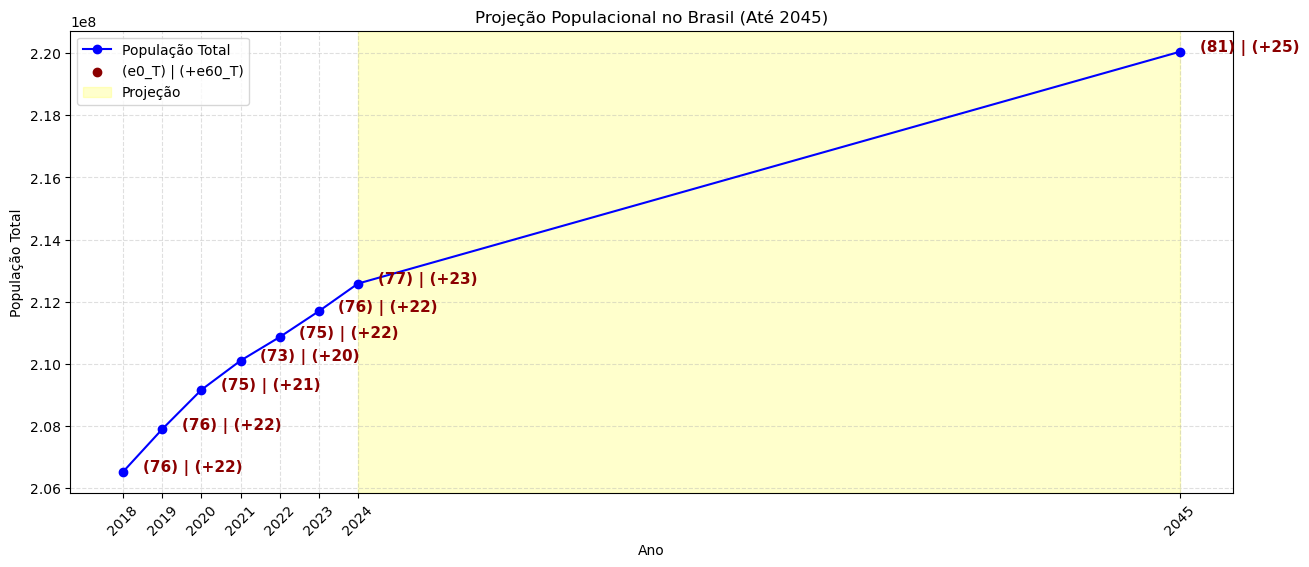

In [159]:
# Criar o gráfico principal
plt.figure(figsize=(15, 6))

pop_T = projecoes2_df_filtrado["POP_H"]+projecoes2_df_filtrado["POP_M"]

plt.plot(projecoes2_df_filtrado["ANO"], pop_T,
         marker="o", linestyle="-", color="b", label="População Total")

# Adicionar valores nos pontos do gráfico
for ano, pop, e0_T, e60_T in zip(projecoes2_df_filtrado["ANO"], 
                                 projecoes2_df_filtrado["POP_H"]+projecoes2_df_filtrado["POP_M"], 
                                 projecoes2_df_filtrado["e0_T"], 
                                 projecoes2_df_filtrado["e60_T"]):

    plt.text(ano + 0.5, pop, f"({e0_T:,.0f}) | (+{e60_T:,.0f})", 
             ha="left", fontsize=11, color="darkred", fontweight="bold")

# Criar um marcador invisível para incluir na legenda
plt.scatter([], [], color="darkred", label="(e0_T) | (+e60_T)")

# Destacar uma região com transparência (exemplo: entre os anos 2024 e 2045)
plt.axvspan(2024, 2045, color="yellow", alpha=0.2, label="Projeção")

# Personalização
plt.xlabel("Ano")
plt.ylabel("População Total")
plt.title("Projeção Populacional no Brasil (Até 2045)")
plt.xticks(projecoes2_df_filtrado["ANO"], rotation=45)  # Rotacionar anos no eixo x
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# Mostrar o gráfico
plt.show()


### GRÁFICOS - Tabela 2: Perfil etário FEITO

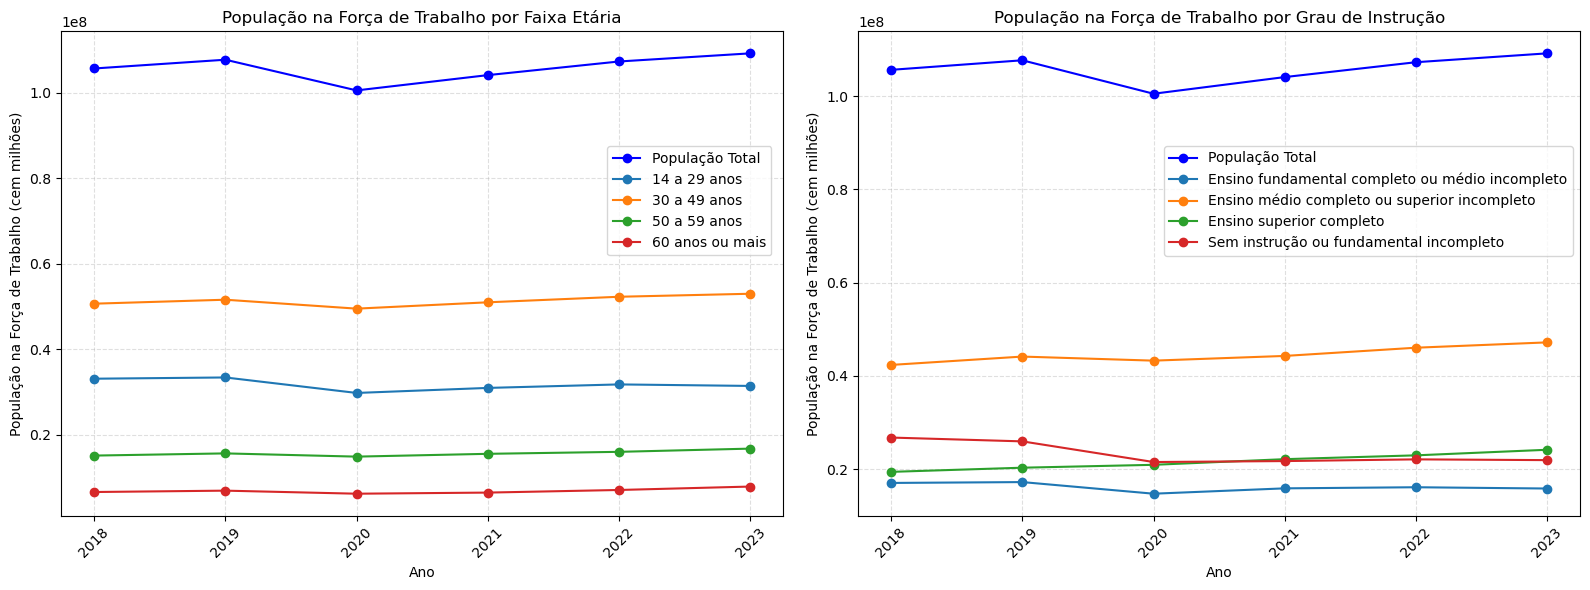

In [170]:
# Criar o gráfico com 1 linha e 2 colunas
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: População por faixa etária ao longo dos anos
axs[0].plot(etario_filtrado["year"].unique(), 
            etario_filtrado.groupby("year")["work_pop"].sum(), 
            marker="o", linestyle="-", color="b", label="População Total")

# Definindo as faixas etárias
faixas_etarias = [
    "14 a 29 anos", 
    "30 a 49 anos", 
    "50 a 59 anos", 
    "60 anos ou mais"
]

# Iterando sobre as faixas etárias e gerando o gráfico para cada uma
for faixa in faixas_etarias:
    faixa_data = etario_filtrado[etario_filtrado["features"] == faixa]
    axs[0].plot(faixa_data["year"].unique(), 
                faixa_data.groupby("year")["work_pop"].sum(), 
                marker="o", linestyle="-", label=faixa)

# Adicionar rótulos e título para o gráfico 1
axs[0].set_xlabel("Ano")
axs[0].set_ylabel("População na Força de Trabalho (cem milhões)")
axs[0].set_title("População na Força de Trabalho por Faixa Etária")
axs[0].tick_params(axis="x", rotation=45)
axs[0].grid(True, linestyle="--", alpha=0.4)
axs[0].legend(loc="center", bbox_to_anchor=(0.87, 0.65))

# Gráfico 2: População por grau de instrução ao longo dos anos
axs[1].plot(etario_filtrado["year"].unique(),
            etario_filtrado.groupby("year")["work_pop"].sum(),
            marker="o", linestyle="-", color="b", label="População Total")

# Agrupar os dados por ano e grau de instrução, somando a população de homens e mulheres
total_por_grau = socio_filtrado.groupby(['year', 'degree'])['work_pop'].sum().reset_index()

# Plotando a soma da população para cada grau de instrução ao longo dos anos
for grau in total_por_grau['degree'].unique():
    grau_data = total_por_grau[total_por_grau['degree'] == grau]
    axs[1].plot(grau_data["year"], grau_data["work_pop"], marker="o", linestyle="-", label=grau)

# Adicionar rótulos e título para o gráfico 2
axs[1].set_xlabel("Ano")
axs[1].set_ylabel("População na Força de Trabalho (cem milhões)")
axs[1].set_title("População na Força de Trabalho por Grau de Instrução")
axs[1].tick_params(axis="x", rotation=45)
axs[1].grid(True, linestyle="--", alpha=0.4)
axs[1].legend(loc="center right", bbox_to_anchor=(1, 0.65))

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()


### GRÁFICOS - Tabela 3: Perfil socio/econômico TERMINAR

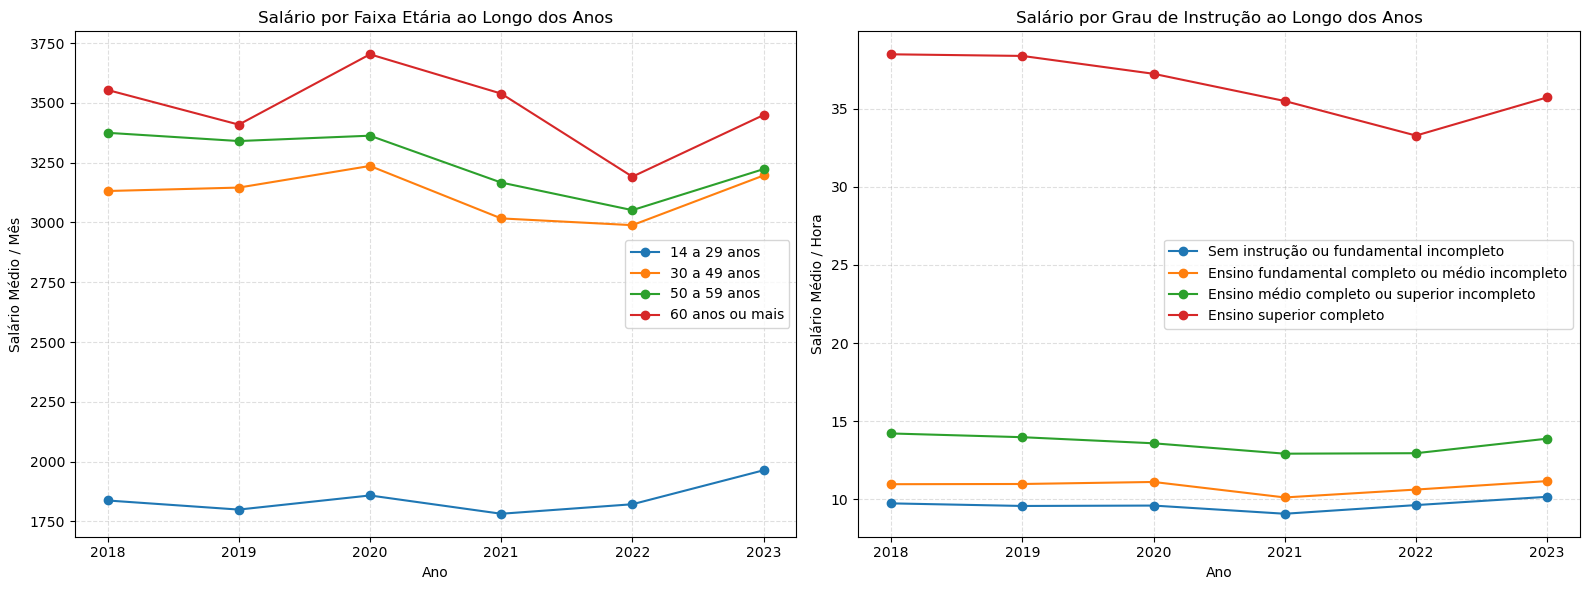

In [165]:
# Criar a figura com 2 gráficos lado a lado
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Salário (X) vs Ano (Y) - Grau de Instrução
for col in ["14 a 29 anos", "30 a 49 anos", "50 a 59 anos", "60 anos ou mais"]:
    axs[0].plot(idade_inst_sal["year"], idade_inst_sal[col], marker="o", linestyle="-", label=col)

axs[0].set_xlabel("Ano")
axs[0].set_ylabel("Salário Médio / Mês")
axs[0].set_title("Salário por Faixa Etária ao Longo dos Anos")
axs[0].grid(True, linestyle="--", alpha=0.4)
axs[0].legend(loc="best")

# Gráfico 2: Salário (X) vs Ano (Y) - Faixa Etária
for legenda, coluna in colunas_desejadas_INST.items():
    axs[1].plot(idade_inst_sal["year"], idade_inst_sal[coluna], marker="o", linestyle="-", label=legenda)

axs[1].set_xlabel("Ano")
axs[1].set_ylabel("Salário Médio / Hora")
axs[1].set_title("Salário por Grau de Instrução ao Longo dos Anos")
axs[1].grid(True, linestyle="--", alpha=0.4)
axs[1].legend(loc="best")
    
plt.tight_layout()
plt.show()


## Gráficos das querys

### Gráfico 1

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Configurar conexão com MySQL
usuario = "seu_usuario"
senha = "sua_senha"
host = "seu_host"  # Exemplo: "localhost"
banco = "seu_banco"

# Criando a conexão com o banco de dados
engine = create_engine(f"mysql+mysqlconnector://{usuario}:{senha}@{host}/{banco}")

# Caminho relativo ao arquivo SQL dentro da pasta DBT
sql_file_path = "../DBT/consulta.sql"

# Ler a query do arquivo SQL
with open(sql_file_path, "r", encoding="utf-8") as file:
    query = file.read()

# Executar a query no banco de dados e carregar os dados em um DataFrame Pandas
df = pd.read_sql(query, engine)

# Visualizar os primeiros registros
print(df.head())

# Fechar a conexão
engine.dispose()
